## Lab 2 ##
Kar Lok Ng

8971216

### Part A ###

In [454]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import confusion_matrix, f1_score

random.seed(42)

# Loading the data
lab2_data_path = \
    "/Users/karlokng/Documents/fall_2023/CSCN8000/CSCN8000_Fall2023/practical_labs/datasets/Lab_2/Lab2_dataset.csv"
lab2_data = pd.read_csv(lab2_data_path, index_col= 0)

# take a sample for development purposes
#lab2_data = lab2_data.iloc[:100]

lab2_data.sort_index(inplace= True)

### Pre-Processing ###

In [455]:
# use CountVectorizer to transform the "text" feature
# Without providing a dictionary, number of features would default to vocab size
# (i.e. number of features = number of unique words in "text")

# transform the data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(lab2_data['text'])

# toarray() makes it a 5171 x 50447 array
# tolist() converts the array to a list of lists of length 5171
# where each list is the tokenized "text"
X_arr = X.toarray()

# splitting to training and testing
X_train, X_test, y_train, y_test = train_test_split(X_arr, \
                                                    lab2_data['label_num'], train_size= 0.8)

### Model Training and Evaluation ###

In [456]:
# TRAINING CELL
# takes awhile...
model1 = SVC()
model1.fit(X_train, y_train)

model2 = MultinomialNB()
model2.fit(X_train, y_train)

model3 = GaussianNB()
model3.fit(X_train, y_train)

GaussianNB()

In [457]:
# Evaluation
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)

conf1 = confusion_matrix(y_test, y_pred1)
conf2 = confusion_matrix(y_test, y_pred2)
conf3 = confusion_matrix(y_test, y_pred3)

# the count of true negatives is C_00, false negatives is C_10, 
# true positives C_11 is and false positives is C_01.
print(conf1)
print(conf2)
print(conf3)

[[696  27]
 [ 13 299]]
[[714   9]
 [ 16 296]]
[[714   9]
 [ 32 280]]


In [458]:
score1 = f1_score(y_test, y_pred1)
score2 = f1_score(y_test, y_pred2)
score3 = f1_score(y_test, y_pred3)

print(score1, score2, score3)

0.9373040752351097 0.9594813614262561 0.9317803660565723


By looking at the confusion matrices, we see that all 3 models perform quite well. We also see that the two Naive Bayes classifier perform much more similarly to each other as compared to the SVM method.

The SVM classifier works by trying to draw a decision boundary between the classes in the feature space. It "learns" this decision boundary by trying to find a hyperplane that maximize the margin between the points and the boundary. Thus it does not make any prior assumptions about the conditional probabilities of the features we have, unlike the Naive Bayes methods. 

We note that the true negative and false positive counts for the two Naive Bayes methods are quite similar, and the difference in performance is most noticeable between the false negative and true positives count. This could indicate that the Gaussian method of attaining the probabilities $p(x_i | C_k)$ is more biased towards an email being negative than positive compared to the Multinomial method. 

Another metric we could look at is the F-score. The F-score is the harmonic mean (a fancy arithmetic mean where all the numerator terms are reciprocated) between precision (the proportion of true positives in all entries flagged as positive) and the recall (the proportion of true positives flagged wthin all the "actual" positives which should all been flagged as positive). All 3 models performed very well, although the MultinomialNB classifier performed best. 

Since we are working with textual data and our input space is not continuous, I would personally choose MultinomialNB rather than GaussianNB. Although the SVM's lack of prior assumptions regarding our features is nice, it does not perform as well as MultinomialNB in our case, as such perhaps we could choose MultinomialNB classfier amongst the 3. 

NOTE: Sorry for the amount of brackets in my explanation of the F_score. I couldn't really think of a better way to define all the terms. ALSO I've always been a little confused about how the kernel trick works in SVM to find non-linear boundaries. I hope that's something we would cover eventually.

### Part B ###

In [459]:
ab_nyc_2019_path = "/Users/karlokng/Documents/fall_2023/CSCN8000/CSCN8000_Fall2023/practical_labs/datasets/Lab_2/AB_NYC_2019.csv"
ab_nyc_2019 = pd.read_csv(ab_nyc_2019_path, index_col=0)

In [460]:
def z_score_filter(data_col, threshold= 3):
    """
    Description: A z_score filter that assigns each element \
        True if outlier, False otherwise
    Input: A Series of numerical data (int or floats), \
        optionally a custom threshold
    Output: A Series of boolean values
    """
    data_mean = data_col.mean()
    data_sd = data_col.std()

    # Now I calculate the z_score
    z_score = (data_col - data_mean)/data_sd

    return pd.Series([(element < -threshold or element > threshold) \
                      for element in z_score], index= data_col.index)

def box_whisker_filter(data_col):
    """
    Description: A box_whisker based filter that assigns each element\
        True if outlier, False otherwise
    Input: A Series of numerical data (int or floats)
    Output: A Series of boolean values
    """

    # compute the quantiles
    q1 = data_col.quantile(0.25)
    q3 = data_col.quantile(0.75)

    # get the IQR and the lower bound(lb) and the upper bound(ub)
    iqr = q3 - q1
    lb = q1 - 1.5*iqr
    ub = q3 + 1.5*iqr

    return pd.Series([(element < lb or element > ub) \
                      for element in data_col], index= data_col.index)

In [461]:
# We can filter the outliers using each method by first appending
# the bool values from the function onto the dataframe
ab_nyc_2019['z_score_filter'] = z_score_filter(ab_nyc_2019['price'])
ab_nyc_2019['box_whisker_filter'] = box_whisker_filter(ab_nyc_2019['price'])

# We then filter by the value from the corresponding column
ab_nyc_2019_z_score = ab_nyc_2019.iloc[:,:-2][ab_nyc_2019['z_score_filter'] == False]
ab_nyc_2019_box_whisker = ab_nyc_2019.iloc[:,:-2][ab_nyc_2019['box_whisker_filter'] == False]

print(ab_nyc_2019.shape)
print(ab_nyc_2019_z_score.shape)
print(ab_nyc_2019_box_whisker.shape)

(48895, 17)
(48507, 15)
(45923, 15)


The default threshold value (3 standard deviations above/below the mean) is much more loose as a filter compared to the box whisker method of $\pm 1.5IQR$. To get a better idea of which method would be more suitable, we can plot the distribution of "price".

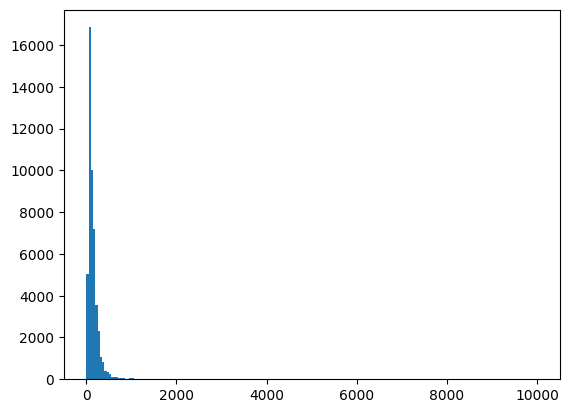

In [462]:
plt.hist(ab_nyc_2019['price'], bins= 200)
plt.show()

We can see that the distribution is heavily right skewed, with a very sharp peak. This would mean that the IQR would be relatively low, which would lead to our box-whiskers method of outlier detection being much more stringent than our z-score based method.

Given that only ~3000 observations are taken out with the more stringent box-whisker approach (out of ~49,000, about 6%), I would choose the box-whisker approach over the z-score approach as we still have a good amount of data for modelling.